In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import cv2
from IPython.display import set_matplotlib_formats, HTML, Image, display
from loaders import load_all_videos, load_thumbnails, each_thumbnail, create_thumbs_df, load_thumbnail

%matplotlib inline
# set_matplotlib_formats('svg')

tqdm.tqdm.pandas()

sns.set()

def imshow(bgr):
    _,ret = cv2.imencode('.png', bgr)
    i = Image(data=ret)
    display(i)

/Users/matis/Studia/3rd-sem/PED/youtube-trending-prediction/.venv/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
vids = load_all_videos()
load_thumbnails(vids)

100%|██████████| 8607/8607 [00:01<00:00, 5652.84it/s]

Downloaded: 0
Broken links: 0
Already present: 7928
Skipped: 679


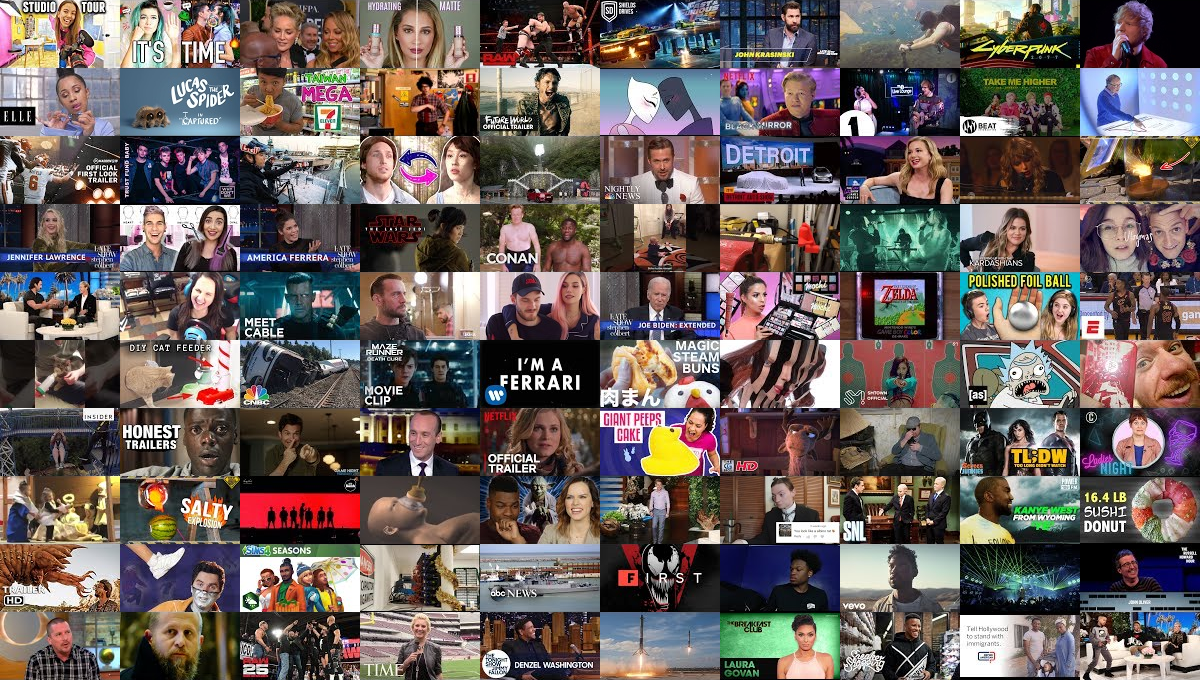

In [3]:
rows = 10
cols = 10
sample = [image for _, image in each_thumbnail(rows * cols)]
w, h, d = sample[0].shape
collage = np.array(sample).reshape(rows, cols, w, h, d).swapaxes(1, 2).reshape(rows * w, cols * h, d)
imshow(collage)

## Color palette analysis

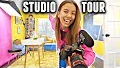

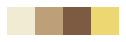

[Hsl(h=32, s=136, l=227), Hsl(h=24, s=89, l=155), Hsl(h=18, s=77, l=95), Hsl(h=35, s=194, l=175)]


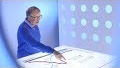

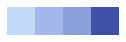

[Hsl(h=151, s=208, l=222), Hsl(h=158, s=170, l=200), Hsl(h=158, s=129, l=177), Hsl(h=162, s=116, l=114)]


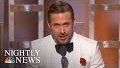

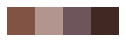

[Hsl(h=10, s=78, l=98), Hsl(h=8, s=46, l=159), Hsl(h=244, s=31, l=97), Hsl(h=7, s=81, l=50)]


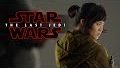

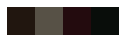

[Hsl(h=16, s=95, l=24), Hsl(h=27, s=27, l=78), Hsl(h=249, s=133, l=23), Hsl(h=95, s=46, l=11)]


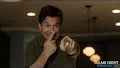

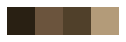

[Hsl(h=25, s=93, l=30), Hsl(h=21, s=69, l=84), Hsl(h=24, s=79, l=61), Hsl(h=24, s=70, l=150)]


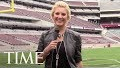

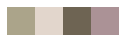

[Hsl(h=33, s=41, l=154), Hsl(h=19, s=70, l=215), Hsl(h=26, s=35, l=96), Hsl(h=248, s=33, l=158)]


In [4]:
import PIL
import colorgram

test = [sample[i] for i in [0, 19, 25, 33, 62, 93]]

def extract_palette(bgr):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    img = PIL.Image.fromarray(rgb)
    return colorgram.extract(img, 4)

def show_palette(palette):
    swatch = np.array([[list(color.rgb) for color in palette]])
    plt.figure(figsize=(2,8))
    plt.imshow(swatch)
    plt.axis('off')
    plt.show()

for image in test:
    palette = extract_palette(image)
    imshow(image)
    show_palette(palette)
    print([color.hsl for color in palette])

In [5]:
thumbs = create_thumbs_df()
thumbs

video_id
0     Cs2Xr2b7ako
1     Di4QJUCElgs
2     i6htP19PyEU
3     ZYXIAzqOgoY
4     mCx26FLXWuI
...           ...
7923  nQ7mhC5_Rys
7924  akohTFyGu88
7925  i9EyFghIt5o
7926  6uJf2IT2Zh8
7927  VTVLcK2zybM

[7928 rows x 1 columns]

In [6]:
hsl_zeros = { f"{x}{i}": 0 for i in range(4) for x in ['h', 's', 'l'] }
thumbs = thumbs.assign(**hsl_zeros)

def hsl_attributes(row):
    im = load_thumbnail(row['video_id'])
    for i, color in enumerate(extract_palette(im)):
        row[f"h{i}"] = int(color.hsl.h / 255 * 360)
        row[f"s{i}"] = int(color.hsl.s / 255 * 100)
        row[f"l{i}"] = int(color.hsl.l / 255 * 100)
    return row

thumbs = thumbs.progress_apply(hsl_attributes, axis=1)
thumbs

100%|██████████| 7928/7928 [04:15<00:00, 31.03it/s]


video_id   h0  s0  l0   h1  s1  l1   h2  s2  l2   h3  s3  l3
0     Cs2Xr2b7ako   45  53  89   33  34  60   25  30  37   49  76  68
1     Di4QJUCElgs   32  53  87   25  27  64   19  56  12   16  34  38
2     i6htP19PyEU   19  32  36   25  46  14  231  10  14   16  39  60
3     ZYXIAzqOgoY   21  23  61   31  17  40  100   6  44   28  42  15
4     mCx26FLXWuI   11  53   7  347  47   8    8  28  38  227  16   5
...           ...  ...  ..  ..  ...  ..  ..  ...  ..  ..  ...  ..  ..
7923  nQ7mhC5_Rys  299  37  94  232   8  62  227   6  41   49   6  36
7924  akohTFyGu88  240  10  96  338  71  95    8  69  96  355  78  55
7925  i9EyFghIt5o  194  49  56  194  67  45  194  70  40  145  12  57
7926  6uJf2IT2Zh8    0  20   2  197  18  10  347  44  10  163  11   6
7927  VTVLcK2zybM   28  19  36   26  25  15   22  21  61   28  44  86

[7928 rows x 13 columns]

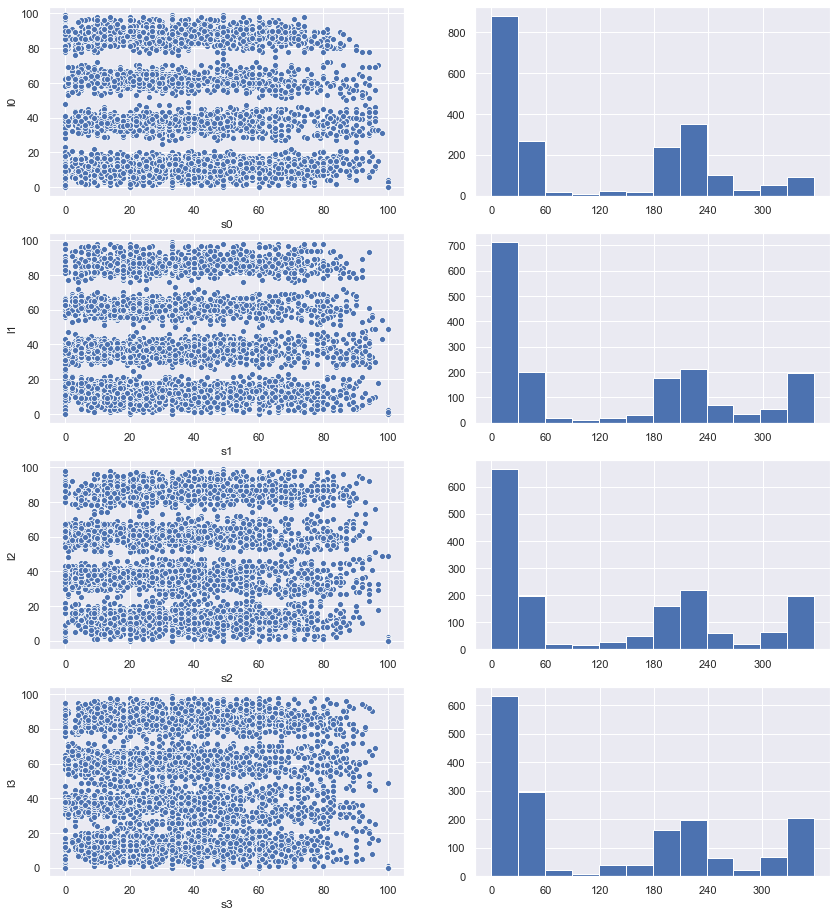

In [7]:
plt.figure(figsize=(14, 16))
for i in range(4):
    plt.subplot(4, 2, 2*i+1)
    sns.scatterplot(x=f"s{i}", y=f"l{i}", data=thumbs)
    plt.subplot(4, 2, 2*i+2)
    sl_filter = (thumbs[f"s{i}"] > 40) & (thumbs[f"s{i}"] > 30) & (thumbs[f"s{i}"] < 70)
    plt.hist(thumbs[sl_filter][f"h{i}"], bins=12)
    plt.xticks(np.arange(6) * 60)
plt.show()

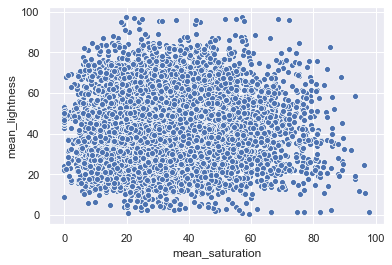

In [8]:
thumbs['mean_saturation'] = (thumbs['s0'] + thumbs['s1'] + thumbs['s2'] + thumbs['s3']) / 4
thumbs['mean_lightness'] = (thumbs['l0'] + thumbs['l1'] + thumbs['l2'] + thumbs['l3']) / 4

sns.scatterplot(x='mean_saturation', y='mean_lightness', data=thumbs)

(array([2536.,  762.,  477.,  325.,  249.,  228.,  288.,  497.,  848.,
        1718.]),
 array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.]),
 <a list of 10 Patch objects>)

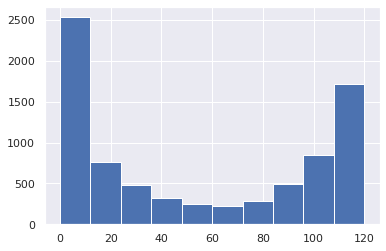

In [9]:
def hue_diff(a, b):
    diff = (a - b).abs()
    return np.array([diff, 360 - diff]).min(axis=0)

h01 = hue_diff(thumbs['h0'], thumbs['h1'])
h12 = hue_diff(thumbs['h1'], thumbs['h2'])
h20 = hue_diff(thumbs['h2'], thumbs['h0'])

mean_hue_diff = (h01 + h12 + h20) / 3
plt.hist(mean_hue_diff)

# Face analysis

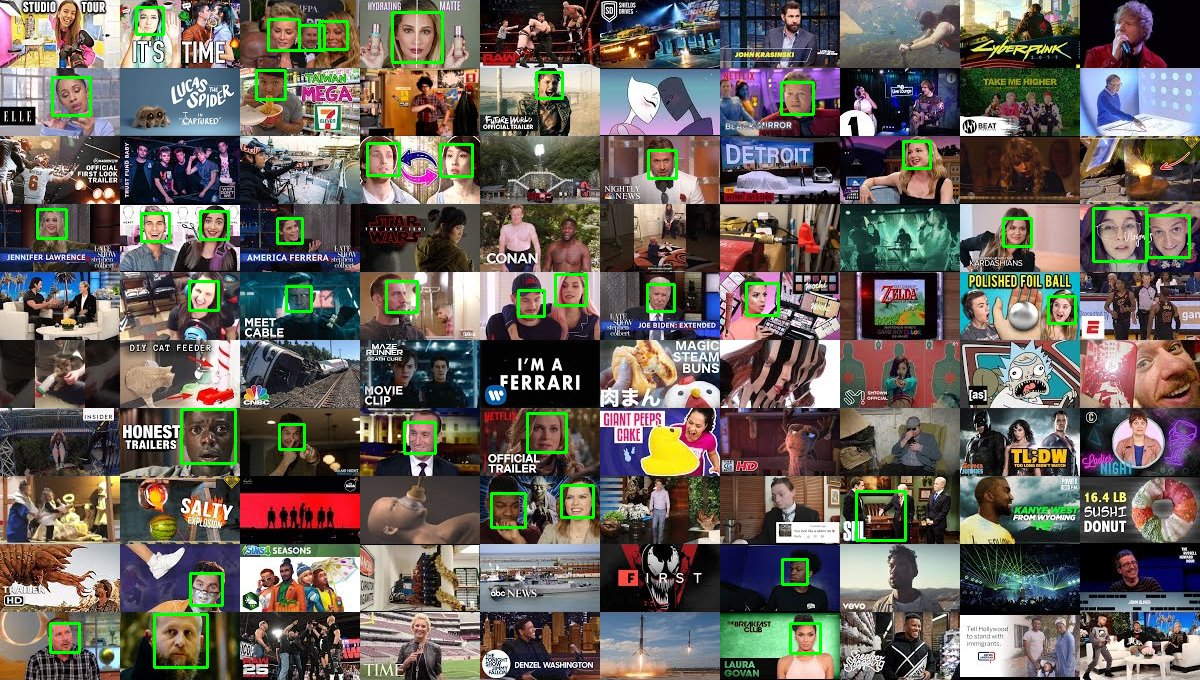

In [95]:
def detect_faces(thumbs):
    face_cascade = cv2.CascadeClassifier('../youtube_data/haarcascade_frontalface_default.xml')
    results = []
    for img in thumbs:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.05, 3)
        
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        results.append(img)
    return results
    
    
rows = 10
cols = 10
sample = [image for _, image in each_thumbnail(rows * cols)]
sample = detect_faces(sample)

w, h, d = sample[0].shape
collage = np.array(sample).reshape(rows, cols, w, h, d).swapaxes(1, 2).reshape(rows * w, cols * h, d)
imshow(collage)


In [52]:
thumbs = create_thumbs_df()
thumbs

video_id
0     Cs2Xr2b7ako
1     Di4QJUCElgs
2     i6htP19PyEU
3     ZYXIAzqOgoY
4     mCx26FLXWuI
...           ...
7923  nQ7mhC5_Rys
7924  akohTFyGu88
7925  i9EyFghIt5o
7926  6uJf2IT2Zh8
7927  VTVLcK2zybM

[7928 rows x 1 columns]

In [96]:
face_cascade = cv2.CascadeClassifier('../youtube_data/haarcascade_frontalface_default.xml')

def detect_faces(row):
    img = load_thumbnail(row['video_id'])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    row['faces'] = faces
    row['faces_count'] = len(faces)
    
    return row

thumbs = thumbs.progress_apply(detect_faces, axis=1)
thumbs






  0%|          | 0/7928 [00:00<?, ?it/s]




  0%|          | 16/7928 [00:00<00:49, 159.18it/s]




  0%|          | 35/7928 [00:00<00:47, 165.52it/s]




  1%|          | 51/7928 [00:00<00:48, 162.87it/s]




  1%|          | 71/7928 [00:00<00:45, 171.87it/s]




  1%|          | 89/7928 [00:00<00:45, 172.98it/s]




  1%|▏         | 109/7928 [00:00<00:43, 178.47it/s]




  2%|▏         | 127/7928 [00:00<00:44, 177.07it/s]




  2%|▏         | 144/7928 [00:00<00:45, 170.80it/s]




  2%|▏         | 162/7928 [00:00<00:45, 171.45it/s]




  2%|▏         | 179/7928 [00:01<00:46, 166.68it/s]




  2%|▏         | 198/7928 [00:01<00:44, 172.35it/s]




  3%|▎         | 216/7928 [00:01<00:45, 170.11it/s]




  3%|▎         | 234/7928 [00:01<00:45, 170.77it/s]




  3%|▎         | 253/7928 [00:01<00:44, 173.90it/s]




  3%|▎         | 271/7928 [00:01<00:46, 164.15it/s]




  4%|▎         | 288/7928 [00:01<00:47, 160.31it/s]




  4%|▍         | 306/7928 [00:01<00:46, 164.85it/s]




  4

 27%|██▋       | 2142/7928 [00:12<00:33, 173.43it/s]




 27%|██▋       | 2162/7928 [00:12<00:32, 179.28it/s]




 28%|██▊       | 2181/7928 [00:12<00:34, 168.93it/s]




 28%|██▊       | 2199/7928 [00:12<00:36, 157.00it/s]




 28%|██▊       | 2220/7928 [00:12<00:33, 168.94it/s]




 28%|██▊       | 2240/7928 [00:12<00:32, 174.80it/s]




 28%|██▊       | 2258/7928 [00:13<00:32, 175.45it/s]




 29%|██▊       | 2276/7928 [00:13<00:33, 169.66it/s]




 29%|██▉       | 2298/7928 [00:13<00:31, 181.25it/s]




 29%|██▉       | 2318/7928 [00:13<00:30, 185.46it/s]




 30%|██▉       | 2339/7928 [00:13<00:29, 190.99it/s]




 30%|██▉       | 2359/7928 [00:13<00:30, 184.50it/s]




 30%|██▉       | 2378/7928 [00:13<00:31, 177.10it/s]




 30%|███       | 2397/7928 [00:13<00:30, 179.68it/s]




 30%|███       | 2416/7928 [00:13<00:30, 177.93it/s]




 31%|███       | 2435/7928 [00:13<00:30, 180.31it/s]




 31%|███       | 2454/7928 [00:14<00:30, 180.83it/s]




 31%|███       | 2475/7928 [00:

 54%|█████▍    | 4314/7928 [00:24<00:19, 187.63it/s]




 55%|█████▍    | 4333/7928 [00:24<00:19, 188.08it/s]




 55%|█████▍    | 4352/7928 [00:24<00:19, 185.87it/s]




 55%|█████▌    | 4371/7928 [00:25<00:19, 180.89it/s]




 55%|█████▌    | 4393/7928 [00:25<00:18, 189.43it/s]




 56%|█████▌    | 4416/7928 [00:25<00:17, 198.40it/s]




 56%|█████▌    | 4437/7928 [00:25<00:17, 199.55it/s]




 56%|█████▌    | 4458/7928 [00:25<00:17, 196.06it/s]




 56%|█████▋    | 4478/7928 [00:25<00:25, 136.33it/s]




 57%|█████▋    | 4497/7928 [00:25<00:23, 148.38it/s]




 57%|█████▋    | 4517/7928 [00:25<00:21, 160.02it/s]




 57%|█████▋    | 4537/7928 [00:25<00:20, 169.15it/s]




 57%|█████▋    | 4558/7928 [00:26<00:18, 177.66it/s]




 58%|█████▊    | 4580/7928 [00:26<00:17, 187.93it/s]




 58%|█████▊    | 4602/7928 [00:26<00:17, 194.93it/s]




 58%|█████▊    | 4623/7928 [00:26<00:16, 198.79it/s]




 59%|█████▊    | 4644/7928 [00:26<00:24, 133.81it/s]




 59%|█████▉    | 4665/7928 [00:

 81%|████████  | 6429/7928 [00:37<00:08, 184.02it/s]




 81%|████████▏ | 6449/7928 [00:37<00:07, 186.80it/s]




 82%|████████▏ | 6468/7928 [00:37<00:08, 179.87it/s]




 82%|████████▏ | 6487/7928 [00:37<00:08, 174.43it/s]




 82%|████████▏ | 6507/7928 [00:37<00:07, 181.16it/s]




 82%|████████▏ | 6526/7928 [00:37<00:07, 182.99it/s]




 83%|████████▎ | 6545/7928 [00:37<00:07, 184.72it/s]




 83%|████████▎ | 6566/7928 [00:37<00:07, 190.44it/s]




 83%|████████▎ | 6588/7928 [00:38<00:06, 196.92it/s]




 83%|████████▎ | 6608/7928 [00:38<00:06, 197.43it/s]




 84%|████████▎ | 6628/7928 [00:38<00:06, 187.96it/s]




 84%|████████▍ | 6648/7928 [00:38<00:06, 190.39it/s]




 84%|████████▍ | 6668/7928 [00:38<00:06, 184.44it/s]




 84%|████████▍ | 6687/7928 [00:38<00:06, 178.78it/s]




 85%|████████▍ | 6708/7928 [00:38<00:06, 184.62it/s]




 85%|████████▍ | 6727/7928 [00:38<00:06, 185.09it/s]




 85%|████████▌ | 6746/7928 [00:38<00:06, 177.86it/s]




 85%|████████▌ | 6764/7928 [00:

video_id               faces  faces_count
0     Cs2Xr2b7ako                  ()            0
1     Di4QJUCElgs   [[16, 7, 27, 27]]            1
2     i6htP19PyEU  [[27, 19, 31, 31]]            1
3     ZYXIAzqOgoY  [[32, 12, 50, 50]]            1
4     mCx26FLXWuI                  ()            0
...           ...                 ...          ...
7923  nQ7mhC5_Rys                  ()            0
7924  akohTFyGu88                  ()            0
7925  i9EyFghIt5o                  ()            0
7926  6uJf2IT2Zh8                  ()            0
7927  VTVLcK2zybM                  ()            0

[7928 rows x 3 columns]

count    7928.000000
mean        0.231963
std         0.483671
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: faces_count, dtype: float64
Thumbs with at least one face: 1634 (20.61% of all)


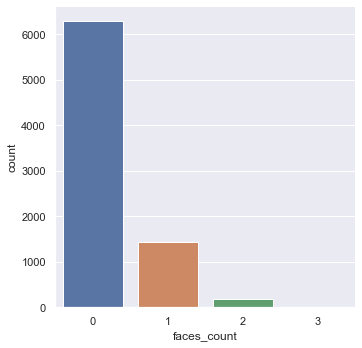

In [117]:
# how many thumbs have faces?
faces_per_thumb = thumbs['faces_count']

print(faces_per_thumb.describe())
sns.catplot(x="faces_count", kind="count", data=thumbs)

thumbs_with_faces = faces_per_thumb.where(faces_per_thumb > 0).count()
faces_ratio = round((thumbs_with_faces / len(thumbs) * 100), 3)
print("Thumbs with at least one face: " + str(thumbs_with_faces) + " (" + str(faces_ratio) + "% of all)")